In [628]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

%load_ext autoreload
%autoreload 2
from trader.utils import *
from trader.tradertk import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


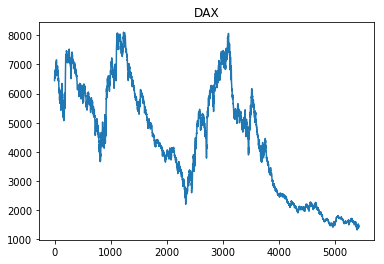

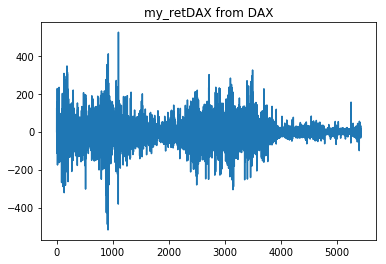

In [629]:
with open('data/retDAX.txt', 'r') as f:
    tmp = f.read()
    
retDAX = list(map(lambda x: float(x), tmp.split()))

with open('data/DAX.txt', 'r') as f:
    tmp = f.read()
    
DAX = list(map(lambda x: float(x), tmp.split()))

plt.plot(DAX)
plt.title('DAX')
plt.show()

# plt.plot(retDAX)
# plt.title('retDAX')
# plt.show()

# print('std(retDAX): ', np.std(retDAX))

tmp = [DAX[0]]
for x in retDAX:
    tmp.append(tmp[-1] + x)

# plt.plot(tmp)
# plt.title('DAX from Returns retDAX')
# plt.show()

my_retDAX = [0]
for i in range(1, len(DAX)):
    my_retDAX.append(DAX[i] - DAX[i-1])
    
plt.plot(my_retDAX)
plt.title('my_retDAX from DAX')
plt.show()

In [630]:
len(my_retDAX)

5426

# Here goes the main part:

# Experimenting....

In [738]:
M = 10  # The number of time series inputs to the trader.
w = np.random.uniform(-0.1, 0.1, M + 3)  # Weights initialization.

miu = 1  # Maximum possible number of shares per transaction.
delta = 0.0006  # Cost for a transaction at period t.
                # 0.0006 is default value in Moscow

learning_rate_0 = 0.01

num_iter_learn = 50  # Number of iterations to learn - optimize w parameters.

window_size = 100  # Historical window size.
start_position = 0
n_steps = 1000  # Nuumber of steps to predict.

F_predictions = []

F_last_value = 0
F_first_value = 0

for t1 in tqdm.tqdm(range(start_position, start_position+n_steps)):
    t_pred = t1 + window_size
    
    learning_rate = learning_rate_0 * (n_steps - t1) / n_steps
#     learning_rate = learning_rate_0
    
    
    ###
    ###
    ###
#     maxT = window_size
#     for iterr in range(1):
#         X = []
#         for t in range(M+1):
#             tmp = [1]
#             tmp.extend(list(reversed(my_retDAX[:t+1])))
#             tmp.extend([0 for i in range(M-t)])
#             if t == 0:
#                 tmp.append(0)
#             else:
#                 tmp.append(traderFunction(w, X[t-1]))
#             X.append(tmp)
#         for t in range(M+1, maxT):
#             X.append(get_x(t, my_retDAX, w, X))
#         X = np.array(X)
#         F = X[:,M+2]
#         def get_reward(t_input, r_input, F_input, miu_input, delta_input):
#             if t_input > 0:
#                 return miu_input * ((F_input[t_input-1] * r_input[t_input]) - \
#                                     (delta_input * abs(F_input[t_input] - F_input[t_input-1])))
#             else:
#                 return 0
            
#         rewards = [get_reward(t, my_retDAX, F, miu, delta) for t in range(maxT)]
#         srs = [sharpRatio(rewards[:t]) for t in range(1, maxT)]
#         dFt = [(1 - (traderFunction(X[0], w) ** 2)) * X[0]]
#         for t in range(1,maxT):
#             dFt.append((1 - (traderFunction(X[t], w) ** 2)) * (X[t] + (w[-1] * dFt[-1])))
#         A = sum(rewards) / maxT
#         B = sum(np.array(rewards) ** 2) / maxT
#         dSdA = (1 / np.sqrt(B - (A ** 2))) + ((A ** 2) / ((B - (A ** 2)) ** (3/2)))
#         dSdB = -1 * (A / (2 * (((B - (A ** 2))) ** (3/2))))

#         grad_old = 0.0
#         for t in range(1, maxT):
#             dAdR = 1 / maxT
#             dBdR = 2 * rewards[t] / maxT
#             dRdFt = -1 * miu * delta * np.sign(F[t] - F[t-1])
#             dRdFtt = (miu * my_retDAX[t]) - dRdFt
#             dFtdw = dFt[t]
#             dFttdw = dFt[t-1]
            
#             grad_old += (dSdA*dAdR + dSdB*dBdR) * (dRdFt*dFtdw + dRdFtt*dFttdw)
    ###
    ###
    ###
    
    for _ in range(num_iter_learn):
        X = build_x_matrix(t1, window_size, M, my_retDAX, w, F_first_value)
        F = get_trader_func(X)
        Rewards, s_ratio = get_rewards(t1, my_retDAX, F, miu, delta)
        dFt = get_grad_F_w(X, w)
        
        grad = get_grad_S_w(t1, Rewards, my_retDAX, F, miu, delta, dFt)

        w += learning_rate * grad
    
    F_first_value = F[1]
    F_last_value = F[-1]
    
    F_predictions.append(traderFunction(build_x_vector(t_pred, M, my_retDAX, F_last_value), w))
    
# print(grad - grad_old)
# print(grad)

100%|██████████| 1000/1000 [02:31<00:00,  7.04it/s]


ValueError: operands could not be broadcast together with shapes (13,) (23,) 

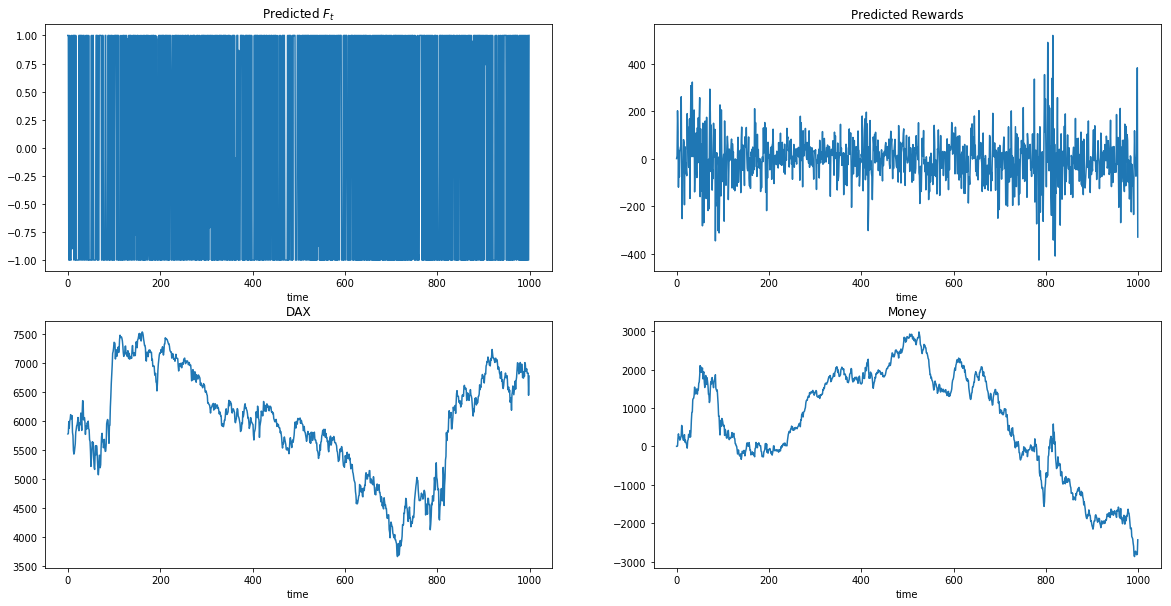

In [739]:
rewards_predictions, sharp = get_rewards(maxT, my_retDAX, np.array(F_predictions), miu, delta)

money = [0]
for i in range(1, len(rewards_predictions)):
    money.append(sum(rewards_predictions[:i]))

plt.figure(figsize=(20,10))
    
plt.subplot(221)
plt.plot(F_predictions)
plt.title('Predicted $F_t$')
plt.xlabel('time')
# plt.show()

plt.subplot(222)
plt.plot(rewards_predictions)
plt.title('Predicted Rewards')
plt.xlabel('time')
# plt.show()

plt.subplot(223)
plt.plot(DAX[start_position+maxT:start_position+maxT+n_steps])
plt.title('DAX')
plt.xlabel('time')
# plt.show()

plt.subplot(224)
plt.plot(money)
plt.title('Money')
plt.xlabel('time')
plt.show()

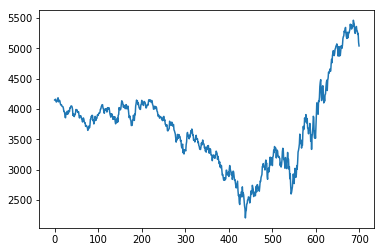

In [576]:
plt.plot(DAX[1900:2600])

In [744]:
orcl_data = pd.read_csv('data/yah_stocks/ORCL.csv')
orcl_close = orcl_data['Close']

my_retORCL = [0]
for i in range(1, len(orcl_close)):
    my_retORCL.append(orcl_close[i] - orcl_close[i-1])

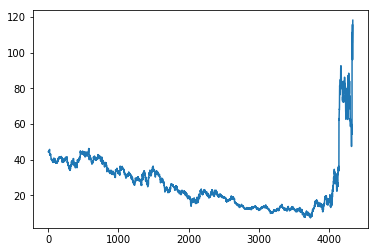

In [746]:
plt.plot(orcl_close)

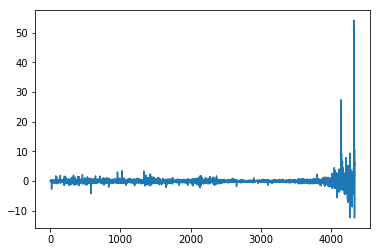

In [747]:
plt.plot(my_retORCL)

In [748]:
M = 20  # The number of time series inputs to the trader.
w = np.random.uniform(-0.1, 0.1, M + 3)  # Weights initialization.

miu = 1  # Maximum possible number of shares per transaction.
delta = 0.0006  # Cost for a transaction at period t.
                # 0.0006 is default value in Moscow

learning_rate_0 = 0.01

num_iter_learn = 50  # Number of iterations to learn - optimize w parameters.

window_size = 100  # Historical window size.
start_position = 0
n_steps = 1000  # Nuumber of steps to predict.

F_predictions = []

F_last_value = 0
F_first_value = 0

for t1 in tqdm.tqdm(range(start_position, start_position+n_steps)):
    t_pred = t1 + window_size
    
    learning_rate = learning_rate_0 * (n_steps - t1) / n_steps
    
    for _ in range(num_iter_learn):
        X = build_x_matrix(t1, window_size, M, my_retORCL, w, F_first_value)
        F = get_trader_func(X)
        Rewards, s_ratio = get_rewards(t1, my_retORCL, F, miu, delta)
        dFt = get_grad_F_w(X, w)
        
        grad = get_grad_S_w(t1, Rewards, my_retORCL, F, miu, delta, dFt)

        w += learning_rate * grad
    
    F_first_value = F[1]
    F_last_value = F[-1]
    
    F_predictions.append(traderFunction(build_x_vector(t_pred, M, my_retORCL, F_last_value), w))

100%|██████████| 1000/1000 [02:46<00:00,  4.94it/s]


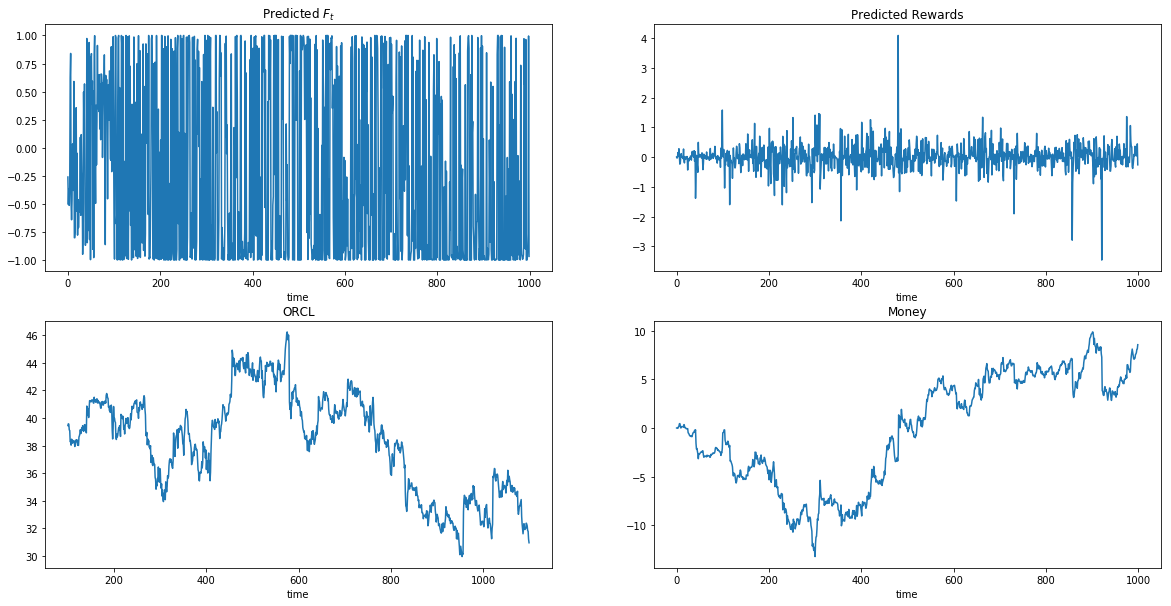

In [749]:
rewards_predictions, sharp = get_rewards(maxT, my_retORCL, np.array(F_predictions), miu, delta)

money = [0]
for i in range(1, len(rewards_predictions)):
    money.append(sum(rewards_predictions[:i]))

plt.figure(figsize=(20,10))
    
plt.subplot(221)
plt.plot(F_predictions)
plt.title('Predicted $F_t$')
plt.xlabel('time')
# plt.show()

plt.subplot(222)
plt.plot(rewards_predictions)
plt.title('Predicted Rewards')
plt.xlabel('time')
# plt.show()

plt.subplot(223)
plt.plot(orcl_close[start_position+maxT:start_position+maxT+n_steps])
plt.title('ORCL')
plt.xlabel('time')
# plt.show()

plt.subplot(224)
plt.plot(money)
plt.title('Money')
plt.xlabel('time')
plt.show()

In [752]:
csco_data = pd.read_csv('data/yah_stocks/CSCO.csv')
csco_close = csco_data['Close']

my_retCSCO = [0]
for i in range(1, len(csco_close)):
    my_retCSCO.append(csco_close[i] - csco_close[i-1])

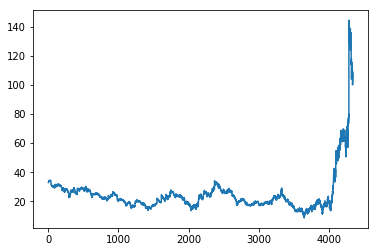

In [753]:
plt.plot(csco_close)

In [757]:
M = 25  # The number of time series inputs to the trader.
w = np.random.uniform(-0.1, 0.1, M + 3)  # Weights initialization.

miu = 1  # Maximum possible number of shares per transaction.
delta = 0.0006  # Cost for a transaction at period t.
                # 0.0006 is default value in Moscow

learning_rate_0 = 0.01

num_iter_learn = 100  # Number of iterations to learn - optimize w parameters.

window_size = 200  # Historical window size.
start_position = 0
n_steps = 3000  # Nuumber of steps to predict.

F_predictions = []

F_last_value = 0
F_first_value = 0

for t1 in tqdm.tqdm(range(start_position, start_position+n_steps)):
    t_pred = t1 + window_size
    
#     learning_rate = learning_rate_0 * (n_steps - t1) / n_steps
    learning_rate = learning_rate_0
    
    for _ in range(num_iter_learn):
        X = build_x_matrix(t1, window_size, M, my_retCSCO, w, F_first_value)
        F = get_trader_func(X)
        Rewards, s_ratio = get_rewards(t1, my_retCSCO, F, miu, delta)
        dFt = get_grad_F_w(X, w)
        
        grad = get_grad_S_w(t1, Rewards, my_retCSCO, F, miu, delta, dFt)

        w += learning_rate * grad
    
    F_first_value = F[1]
    F_last_value = F[-1]
    
    F_predictions.append(traderFunction(build_x_vector(t_pred, M, my_retCSCO, F_last_value), w))

100%|██████████| 3000/3000 [31:58<00:00,  1.67it/s]


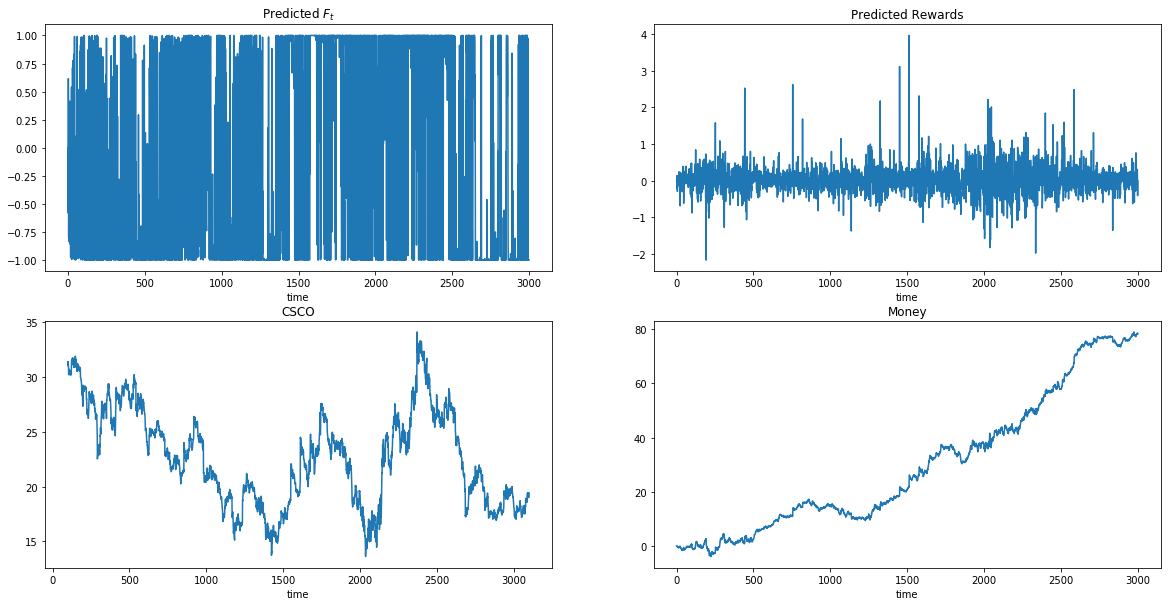

M = 25  # The number of time series inputs to the trader.
w = np.random.uniform(-0.1, 0.1, M + 3)  # Weights initialization.

miu = 1  # Maximum possible number of shares per transaction.
delta = 0.0006  # Cost for a transaction at period t.
                # 0.0006 is default value in Moscow

learning_rate_0 = 0.01

num_iter_learn = 100  # Number of iterations to learn - optimize w parameters.

window_size = 200  # Historical window size.
start_position = 0
n_steps = 3000  # Nuumber of steps to predict.



In [759]:
rewards_predictions, sharp = get_rewards(maxT, my_retCSCO, np.array(F_predictions), miu, delta)

money = [0]
for i in range(1, len(rewards_predictions)):
    money.append(sum(rewards_predictions[:i]))

plt.figure(figsize=(20,10))
    
plt.subplot(221)
plt.plot(F_predictions)
plt.title('Predicted $F_t$')
plt.xlabel('time')
# plt.show()

plt.subplot(222)
plt.plot(rewards_predictions)
plt.title('Predicted Rewards')
plt.xlabel('time')
# plt.show()

plt.subplot(223)
plt.plot(csco_close[start_position+maxT:start_position+maxT+n_steps])
plt.title('CSCO')
plt.xlabel('time')
# plt.show()

plt.subplot(224)
plt.plot(money)
plt.title('Money')
plt.xlabel('time')
plt.show()

print("""M = 25  # The number of time series inputs to the trader.
w = np.random.uniform(-0.1, 0.1, M + 3)  # Weights initialization.

miu = 1  # Maximum possible number of shares per transaction.
delta = 0.0006  # Cost for a transaction at period t.
                # 0.0006 is default value in Moscow

learning_rate_0 = 0.01

num_iter_learn = 100  # Number of iterations to learn - optimize w parameters.

window_size = 200  # Historical window size.
start_position = 0
n_steps = 3000  # Nuumber of steps to predict.
""")